In [1]:
!pip install -U sentence-transformers
!pip install -U arabert

In [2]:
import pandas as pd
import numpy as np
import requests
import json

from google.colab import userdata, drive
drive.mount('/content/drive')
hf_key = userdata.get('huggingface_key')

import os
os.chdir('/content/drive/MyDrive/group-telegram-scraper-main/group-telegram-scraper-main')
print(os.getcwd())
print(os.listdir())

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# from huggingface_hub import InferenceClient
from sklearn.metrics.pairwise import cosine_similarity
# from sentence_transformers import SentenceTransformer



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/group-telegram-scraper-main/group-telegram-scraper-main
['Clustering.ipynb', 'cost_calculator.py', 'Makefile', 'telegram_messages_v3.json', 'README.md', 'top_100_translated.csv', 'google_trn.py', 'evaluate_llm_translation.ipynb', 'playground.ipynb', 'token_counter.py', 'telegram_messages_v2.json', 'openai_client.py', '.gitignore', 'telegram_messages.json', 'telegram_service.py', 'playground_v2.ipynb', 'maps', 'web', 'sentence_embeddings.npy', 'sentence_embeddings_weighted.npy']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Get Arabic stop words
arabic_stopwords = set(stopwords.words('arabic'))

# Function to clean Arabic text
def clean_arabic_text(text):
    # Remove msg meta
    text = text[text.find(':')+1:]

    # Normalize Arabic letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    # Remove diacritics (optional)
    text = re.sub("[ًٌٍَُِّْ]", "", text)
    # Remove unwanted symbols or punctuation (optional)
    # text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"[^a-zA-Z0-9\s\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDCF\uFDF0-\uFDFF\uFE70-\uFEFF]", " ", text)
    # Remove emojis
    # text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F900-\U0001F9FF\U0001F1E0-\U0001F1FF]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stop words
    words = text.split()
    filtered_words = [word for word in words if word not in arabic_stopwords]

    return ' '.join(filtered_words)

In [4]:
df = pd.read_csv('top_100_translated.csv')
df = df[['message', 'gpt-4o.hebrew_translation', 'gpt-4o.english_translation']]
df.columns = ['message', 'heb', 'eng']
df = df[~df['heb'].isna()]

df['clean_msg'] = df['message'].apply(clean_arabic_text)

df = df.reset_index(drop=True)

print(df.shape)
df.head(10)

(86, 4)


,message,heb,eng,clean_msg
0,🛑مصادر محليةاشتباكات مسلحة مع قوات الاحتلال في...,מקורות מקומיים: ירי לעבר כוחות הכיבוש בעיר טובאס,Local sources: Gunfire confrontation with occu...,مصادر محليةاشتباكات مسلحة قوات الاحتلال مدينة ...
1,📍صحفي إسرائيلي متطرف أراد الاحتفال باغتيال يحي...,כתב ישראלי קיצוני רצה לחגוג את ההתנקשות ביהיא ...,An extremist Israeli journalist wanted to cele...,صحفي اسراييلي متطرف اراد الاحتفال باغتيال يحيي...
2,🛑الجو كئيب .. النفس ضيق .. التفكير كثير ومحدا ...,המזג אוויר עגום .. הנשימה כבדה .. המחשבה מרובה...,The weather is gloomy .. the breathing is heav...,الجو كييب النفس ضيق التفكير كثير ومحدا مصدق ال...
3,🛑مصادر محلية تحليق مكثف لطائرات الاستطلاع فوق...,מקורות מקומיים: ריחוף מסיבי של מטוסי סיור מעל ...,Local sources: Intensive flight of reconnaissa...,مصادر محلية تحليق مكثف لطايرات الاستطلاع وسط م...
4,🛑مصادر محلية شهداء ومصابون بقصف طائرات الاحتلا...,מקורות מקומיים: הרוגים ופצועים בהפגזת מטוסי הכ...,Local sources: Martyrs and injuries in the bom...,مصادر محلية شهداء ومصابون بقصف طايرات الاحتلال...
5,🛑حزب اللهاستهدفنا بالصواريخ تجمعا لجنود العدو ...,חזבאללה: תקפנו בטילים ריכוז של חיילי האויב היש...,Hezbollah: We targeted with rockets a gatherin...,حزب اللهاستهدفنا بالصواريخ تجمعا لجنود العدو ا...
6,🛑في سماء شرق غزة وشمال غزة .. الاحتلال يطلق قن...,בשמי מזרח עזה וצפון עזה .. הכיבוש יורה פצצות ת...,In the skies of east and north Gaza .. the occ...,سماء شرق غزة وشمال غزة الاحتلال يطلق قنابل الا...
7,🛑سي إن إن عن مسؤولين أمريكيينالمساعدة في استعا...,סי.אנ.אן: עזרה בשחרור החטופים בעזה קשורה באופן...,CNN: Assistance in recovering hostages in Gaza...,سي ان ان مسوولين امريكيينالمساعدة استعادة الره...
8,🛑مصادر محلية مستوطنون يهاجمون الأهالي ويحرقون ...,מקורות מקומיים: מתנחלים תוקפים את התושבים ושור...,Local sources: Settlers attack residents and b...,مصادر محلية مستوطنون يهاجمون الاهالي ويحرقون م...
9,🛑متابعةلحظة وقوع حادث السير في شارع القدس,מעקב: רגע התרחשות תאונת הדרכים ברחוב ירושלים,Follow-up: Moment of the traffic accident on J...,متابعةلحظة وقوع حادث السير شارع القدس


In [5]:
# client = InferenceClient(
#     "sentence-transformers/distiluse-base-multilingual-cased-v1",
#     token=hf_key,
# )

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch
from arabert.preprocess import ArabertPreprocessor
from tensorflow import Tensor

In [7]:
temp = df.iloc[[5, 55]]
sentences = temp['clean_msg'].to_list()
temp

,message,heb,eng,clean_msg
5,🛑حزب اللهاستهدفنا بالصواريخ تجمعا لجنود العدو ...,חזבאללה: תקפנו בטילים ריכוז של חיילי האויב היש...,Hezbollah: We targeted with rockets a gatherin...,حزب اللهاستهدفنا بالصواريخ تجمعا لجنود العدو ا...
55,🚨 ‏عاجل | بايدن: كان لإسرائيل كل الحق في القضا...,חירום | ביידן: לישראל הייתה כל הזכות לחסל את ה...,Urgent | Biden: Israel had every right to elim...,لاسراييل الحق القضاء علي قيادة حماس وبنيتها ال...


In [17]:
sentences = df['clean_msg'].to_list()

### Building embeddings for similarity

In [18]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(token_embeddings, attention_mask):
    # token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def max_pooling(last_hidden_states, attention_mask):
    # Expand attention mask to match the last_hidden_states shape
    mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_states.size())

    # Set padding tokens to -inf so they are ignored in max pooling
    last_hidden_states[mask_expanded == 0] = float('-inf')

    # Apply max pooling along the sequence length dimension
    max_pooled = torch.max(last_hidden_states, dim=1).values  # (batch_size, hidden_size)

    return max_pooled

def weight_mask(a, mask):
    u, c = np.unique(a, return_counts=True)
    freq = c[np.searchsorted(u, a)]
    rev_freq = 1 / freq

    rev_freq[mask == 0] = 0
    return torch.from_numpy(rev_freq)

def calculate_embeddings(sentences):
    model_name = 'aubmindlab/bert-large-arabertv02'
    # Load model from HuggingFace Hub
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    arabert_prep = ArabertPreprocessor(model_name=model_name)
    prep_sentences = [arabert_prep.preprocess(sentence) for sentence in sentences]

    # Tokenize sentences
    encoded_input = tokenizer(prep_sentences, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling. In this case, mean pooling.
    sentence_embeddings = mean_pooling(model_output.last_hidden_state, encoded_input['attention_mask'])

    print("Sentence embeddings:")
    print(sentence_embeddings.shape)
    print(sentence_embeddings)

    weightened_mask = weight_mask(encoded_input['input_ids'], encoded_input['attention_mask'])
    sentence_embeddings2 = mean_pooling(model_output.last_hidden_state, weightened_mask)

    print("Sentence embeddings: weighted")
    print(sentence_embeddings2.shape)
    print(sentence_embeddings2)

    # sentence_embeddings3 = max_pooling(model_output.last_hidden_state, encoded_input['attention_mask'])

    # print("Sentence embeddings: max")
    # print(sentence_embeddings3.shape)
    # print(sentence_embeddings3)

    return sentence_embeddings, sentence_embeddings2

# np.array(sentence_embeddings).dump('/content/drive/MyDrive/group-telegram-scraper-main/group-telegram-scraper-main/sentence_embeddings.npy')
# np.array(sentence_embeddings2).dump('/content/drive/MyDrive/group-telegram-scraper-main/group-telegram-scraper-main/sentence_embeddings_weighted.npy')

In [19]:
# sentence_embeddings = np.load('/content/drive/MyDrive/group-telegram-scraper-main/group-telegram-scraper-main/sentence_embeddings.npy', allow_pickle=True)
# sentence_embeddings2 = np.load('/content/drive/MyDrive/group-telegram-scraper-main/group-telegram-scraper-main/sentence_embeddings_weighted.npy', allow_pickle=True)

In [20]:
sentence_embeddings, sentence_embeddings2 = calculate_embeddings(sentences)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sentence embeddings:
torch.Size([86, 1024])
tensor([[-1.4163, -1.0886, -0.1443,  ..., -0.9920,  0.3525,  0.6348],
        [-1.0785,  0.3686, -0.5781,  ..., -0.3359, -0.0756,  0.3558],
        [-0.3819,  1.3276, -0.4572,  ..., -0.4783, -0.0301, -0.0598],
        ...,
        [ 0.0313,  0.8669,  0.6458,  ..., -1.0662, -0.2045,  0.2794],
        [ 0.0174,  0.4476, -0.4369,  ..., -0.4660, -0.7720,  0.3251],
        [-0.9767, -0.4143, -0.3102,  ..., -0.5348, -0.3017,  0.1867]])
Sentence embeddings: weighted
torch.Size([86, 1024])
tensor([[-1.1305, -1.1456, -0.3032,  ..., -0.8771,  0.3519,  0.8492],
        [-0.9457,  0.3678, -0.7010,  ..., -0.4046, -0.2982,  0.3762],
        [-0.1020,  1.1254, -0.4180,  ..., -0.4829, -0.2191, -0.0605],
        ...,
        [-0.0392,  0.4469,  0.5987,  ..., -1.1755, -0.3018,  0.4032],
        [-0.3677,  0.1435, -0.8708,  ..., -0.3403, -0.5357,  0.2560],
        [-0.3977, -0.8646, -0.2973,  ..., -0.7481, -0.3871,  0.1960]])


In [21]:
# index = [0, 1]#[75, 11]
# print(df['heb'].iloc[index])
# print('sim')
# print(cosine_similarity(sentence_embeddings[index]))
# print('sim - weight')
# print(cosine_similarity(sentence_embeddings2[index]))
# print('sim - max')
# print(cosine_similarity(sentence_embeddings3[index]))

In [22]:
cosine_matrix = cosine_similarity(sentence_embeddings).round(3)
cosine_matrix2 = cosine_similarity(sentence_embeddings2).round(3)

In [36]:
# find all rows having highly similar msgs
threshold = 0.85  # Adjust as needed

rows = []
rows.extend(np.where((cosine_matrix > threshold) & (cosine_matrix < 1))[0])
rows.extend(np.where((cosine_matrix2 > threshold) & (cosine_matrix2 < 1))[0])
rows = sorted(list(set(rows)))
print(rows)

[2, 22, 24, 26, 29, 31, 32, 35, 40, 46, 47, 49, 50, 59, 67, 71, 72, 73, 74, 77, 82, 85]


In [39]:
i = 22
sim1 = cosine_matrix[i].argsort()[::-1][1:5]
sim2 = cosine_matrix2[i].argsort()[::-1][1:5]

indexes = [i] + list(sim1) + list(sim2)

comp = pd.concat([pd.Series([1] + list(cosine_matrix[i, sim1]) + list(cosine_matrix2[i, sim2]), name='sim'),
                  df['heb'].iloc[indexes].reset_index(drop=True),
                  pd.Series(['orig'] + ['norm'] * 4 + ['wei'] * 4, name='grp')], axis = 1)
comp.set_index(['grp', 'sim'])
# print(df['heb'].iloc[i])  # Print original Heb
# print('embedding - norm')
# for j in range(len(sim1)):
#     print(f"%0.3f {df['heb'].iloc[sim1[j]]}" % cosine_matrix[i, sim1[j]])
# print('embedding - weight')
# for j in range(len(sim2)):
#     print(f"%0.3f {df['heb'].iloc[sim2[j]]}" % cosine_matrix2[i, sim2[j]])


heb
grp  sim                                                     
orig 1.000  התקשורת העברית מפרסמת: תיעוד נוסף של יחיא סינו...
norm 0.906  חדשות ידיעות אחרונות: תיעוד: יחיא סנוואר זמן ק...
     0.874  כוחו של מוחמד סינואר בעזה יגדל והוא יהיה בעל מ...
     0.871  אנחנו עובדים ברצון אלוהים ובפיקוחו, את המפקד מ...
     0.827  דובר צה"ל: חוסל יחיא סינוואר אתמול באזור תל סו...
wei  0.876  חדשות ידיעות אחרונות: תיעוד: יחיא סנוואר זמן ק...
     0.869  אנחנו עובדים ברצון אלוהים ובפיקוחו, את המפקד מ...
     0.845  כוחו של מוחמד סינואר בעזה יגדל והוא יהיה בעל מ...
     0.829  התקשורת העברית: יש חילוקי דעות גדולים כעת בצבא...

In [38]:
temp = df.iloc[indexes]
temp

,message,heb,eng,clean_msg
2,🛑الجو كئيب .. النفس ضيق .. التفكير كثير ومحدا ...,המזג אוויר עגום .. הנשימה כבדה .. המחשבה מרובה...,The weather is gloomy .. the breathing is heav...,الجو كييب النفس ضيق التفكير كثير ومحدا مصدق ال...
32,#عـاجـل - يديعوت أحرونوت:توثيق: يحيى #السنوار ...,חדשות ידיעות אחרונות: תיעוד: יחיא סנוואר זמן ק...,Yediot Aharonot News: Documentation: Yahya Al-...,توثيق يحيي السنوار وقت قصير اقصايه
74,🔴ليس بعد !!!حتى تعلن قيادة حماس ..أنا لا ألتفت...,עדיין לא!!! עד שתכריז הנהגת חמאס... אני לא מתי...,Not yet!!! Until Hamas' leadership officially ...,حتي تعلن قيادة حماس انا التفت الي يصدر او ينشر...
50,🚨 الرئيس الأمريكي جو بايدن عن القضاء على السنو...,"הנשיא האמריקאי ג'ו ביידן על חיסול הסנואר: ""זהו...",U.S. President Joe Biden on the elimination of...,الرييس الامريكي جو بايدن القضاء علي السنوار ان...
35,📍نحن نعمل بإرادة الله وعلى عينه، يخلف القائد ق...,"אנחנו עובדים ברצון אלוהים ובפיקוחו, את המפקד מ...",We work by the will of God and under His sight...,نعمل بارادة الله وعلي عينه، يخلف القايد قادة و...
74,🔴ليس بعد !!!حتى تعلن قيادة حماس ..أنا لا ألتفت...,עדיין לא!!! עד שתכריז הנהגת חמאס... אני לא מתי...,Not yet!!! Until Hamas' leadership officially ...,حتي تعلن قيادة حماس انا التفت الي يصدر او ينشر...
29,📍الاعلام العبري هناك اختلاف كبير الان في الجيش...,התקשורת העברית: יש חילוקי דעות גדולים כעת בצבא...,Hebrew media: There is significant disagreemen...,الاعلام العبري اختلاف كبير الان الجيش الاسرايي...
32,#عـاجـل - يديعوت أحرونوت:توثيق: يحيى #السنوار ...,חדשות ידיעות אחרונות: תיעוד: יחיא סנוואר זמן ק...,Yediot Aharonot News: Documentation: Yahya Al-...,توثيق يحيي السنوار وقت قصير اقصايه
50,🚨 الرئيس الأمريكي جو بايدن عن القضاء على السنو...,"הנשיא האמריקאי ג'ו ביידן על חיסול הסנואר: ""זהו...",U.S. President Joe Biden on the elimination of...,الرييس الامريكي جو بايدن القضاء علي السنوار ان...


<Axes: title={'center': 'Weight'}, ylabel='Frequency'>

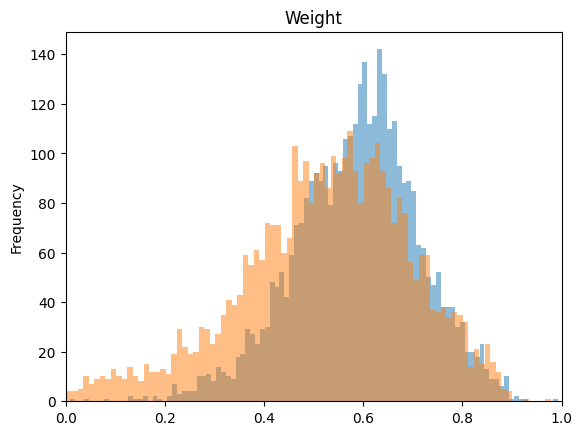

In [35]:
# prompt: take upper triangle from cosine_matrix

upper_triangle = np.triu(cosine_matrix, k=1)
upper_triangle = upper_triangle[upper_triangle != 0]
pd.Series(upper_triangle).plot(kind='hist', xlim=(0, 1), bins=100, title='Norm', alpha=0.5)

upper_triangle2 = np.triu(cosine_matrix2, k=1)
upper_triangle2 = upper_triangle2[upper_triangle2 != 0]
pd.Series(upper_triangle2).plot(kind='hist', xlim=(0, 1), bins=100, title='Weight', alpha=0.5)


### Clustering

In [40]:
from sklearn.cluster import DBSCAN

In [53]:
# prompt: cluster sentence_embeddings with dbscan


# Assuming sentence_embeddings is your array of embeddings
# Replace with your actual embeddings
# sentence_embeddings = ...

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.2, min_samples=2, metric='cosine')  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(sentence_embeddings)

# Add cluster labels to your DataFrame
df['cluster'] = clusters

# Analyze the clusters
print(df['cluster'].value_counts())

# You can further explore the clusters by grouping your data by cluster label
# and examining the sentences within each cluster.
# For example, to print sentences in cluster 0:
# print(df[df['cluster'] == 0]['clean_msg'])

cluster
-1    52
 0    30
 1     2
 2     2
Name: count, dtype: int64


In [55]:
df[df['cluster'] == 1]

,message,heb,eng,clean_msg,cluster,cluster2
57,🚨 عاجل | هاريس: يجب إطلاق سراح المحتجزين وهذه ...,חירום | האריס: יש לשחרר את האסירים ורגע זה נות...,Urgent | Harris: Detainees must be released an...,يجب اطلاق سراح المحتجزين وهذه اللحظة تمنحنا فر...,1,-1
58,🚨 هاريس: هذه اللحظة تمنحنا الفرصة لإنهاء الحرب...,האריס: הרגע הזה נותן לנו את ההזדמנות לסיים את ...,Harris: This moment gives us the opportunity t...,اللحظة تمنحنا الفرصة لانهاء الحرب غزة,1,-1


In [51]:
clusters2 = dbscan.fit_predict(sentence_embeddings2)
df['cluster2'] = clusters2
df['cluster2'].value_counts()

,count
cluster2,
-1,65
0,19
1,2


In [52]:
df[df['cluster2'] == 0]

,message,heb,eng,clean_msg,cluster,cluster2
2,🛑الجو كئيب .. النفس ضيق .. التفكير كثير ومحدا ...,המזג אוויר עגום .. הנשימה כבדה .. המחשבה מרובה...,The weather is gloomy .. the breathing is heav...,الجو كييب النفس ضيق التفكير كثير ومحدا مصدق ال...,-1,0
22,📍الاعلام العبري ينشر:توثيق إضافي ليحيى السنوار...,התקשורת העברית מפרסמת: תיעוד נוסף של יחיא סינו...,Hebrew media publishes: Additional documentati...,توثيق اضافي ليحيي السنوار تصفيته,0,0
24,📍المتحدث باسم جيش الاحتلال الإسرائيلي، فر #ال...,דובר צבא הכיבוש הישראלי: סינוואר נמלט לבדו לאח...,The spokesman for the Israeli Occupation Army ...,المتحدث باسم جيش الاحتلال الاسراييلي، فر السنو...,-1,0
26,📍المتحدث باسم الجيش الإسرائيلي: تمت تصفية يحيى...,"דובר צה""ל: חוסל יחיא סינוואר אתמול באזור תל סו...",IDF Spokesperson: Yahya Sinwar was eliminated ...,تمت تصفية يحيي السنوار امس منطقة تل السلطان بر...,0,0
29,📍الاعلام العبري هناك اختلاف كبير الان في الجيش...,התקשורת העברית: יש חילוקי דעות גדולים כעת בצבא...,Hebrew media: There is significant disagreemen...,الاعلام العبري اختلاف كبير الان الجيش الاسرايي...,0,0
31,📍الجيش ادعى انه قتل هاني زعرب مع #يحيى السنوار...,"הצבא טען כי הרג את האני זרב עם יחיא סנוואר, אך...",The army claimed it killed Hani Zarab with Yah...,الجيش ادعي انه قتل هاني زعرب يحيي السنوار ليخر...,0,0
32,#عـاجـل - يديعوت أحرونوت:توثيق: يحيى #السنوار ...,חדשות ידיעות אחרונות: תיעוד: יחיא סנוואר זמן ק...,Yediot Aharonot News: Documentation: Yahya Al-...,توثيق يحيي السنوار وقت قصير اقصايه,0,0
35,📍نحن نعمل بإرادة الله وعلى عينه، يخلف القائد ق...,"אנחנו עובדים ברצון אלוהים ובפיקוחו, את המפקד מ...",We work by the will of God and under His sight...,نعمل بارادة الله وعلي عينه، يخلف القايد قادة و...,0,0
40,📍#عاجل| المتحدث باسم الجيش الإسرائيلي لCNN:• ل...,"דובר צה""ל ל-CNN: לא ידענו שהסנוואר היה בבניין ...",IDF spokesperson to CNN: We did not know Al-Si...,نكن نعرف ان السنوار المبني المستهدف لكننا علمن...,0,0
46,"🚨 صحيفة ""يديعوت أحرونوت"" العبرية: عناصر النخبة...","""ידיעות אחרונות"" העברית: כוחות עילית של גולני ...","The Hebrew newspaper ""Yedioth Ahronot"": Elite ...",عناصر النخبة جولاني دخلوا مبني يوم امس ان تم ت...,0,0
